# Multivariate Time Series Classification for Event Prediction

## Problem Description

Goal of this challenge is to perform multivariate timeseries classification. Each timeseries in the dataset consists of 89 observations, each of dimension 14 (and hence multivariate). There are 3 possible labels {0, 1, 2}, where labels 1 and 2 are indicators of event occurrences within the duration of the timeseries and a label of 0 stands for the no-event class. Since both labels 1 and 2 indicate events, they can be interpreted as one label "positive" representing one class versus label 0 being indicator of the "negative class". Thus, the classification problem can be treated as a binary classification problem where we predict labels as "positive" (label 1) or "negative" (label 1). Let's get started! 

## Getting Started with the Data

Let's start out by importing necessary modules and reading the data:

In [ ]:
from __future__ import division
import numpy as np
import pandas as pd
from pandas import DataFrame, concat
import itertools
from math import floor, ceil
from numpy import random
import tsfresh
from sklearn import preprocessing
from tsfresh.feature_extraction.settings import MinimalFCParameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, make_scorer, fbeta_score
import matplotlib.pyplot as plt
from keras import optimizers
from keras.optimizers import SGD
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input, Activation, Bidirectional, Dropout
from keras.utils import to_categorical
from xgboost import XGBClassifier
from sklearn.grid_search import GridSearchCV

In [ ]:
df = pd.read_excel("challenge_dataset.xlsx") 
df.head()
print(df.shape)

(18245, 17)


In [ ]:
df = df.drop(['file'],axis=1) # column provides no information
df.head()

,ID_TestSet,bx,by,bz,bl,bm,bn,bmag,vx,vy,vz,vmag,np,tpar,tper,goal
0,2,0.52,3.99,-2.53,0.12,-4.74,-0.33,4.75,-212.49,126.52,94.29,264.67,5.51,141.67,157.74,2
1,2,-0.46,2.83,-0.37,1.47,-2.49,-0.08,2.89,-205.30,121.80,91.70,255.72,6.51,139.22,154.13,2
2,2,0.63,3.69,-2.23,0.10,-4.36,-0.12,4.36,-208.85,119.43,89.61,256.73,6.15,144.39,151.92,2
3,2,1.71,3.79,-1.89,-0.25,-4.46,0.94,4.57,-205.67,124.33,91.95,257.32,6.06,148.72,164.85,2
4,2,0.69,0.82,0.04,0.05,-0.80,0.72,1.08,-212.35,120.57,95.26,262.10,5.97,183.88,153.38,2


In [ ]:
# Sanity check - confirming that all the samples within the same time series have the same "goal" label
group = df.groupby('ID_TestSet')
df2 = group.apply(lambda x: x['goal'].unique())
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df2)

ID_TestSet
2      [2]
5      [1]
8      [1]
11     [1]
14     [2]
17     [2]
20     [2]
23     [2]
26     [2]
29     [2]
32     [2]
35     [2]
38     [2]
41     [2]
44     [1]
47     [0]
50     [1]
53     [1]
56     [1]
59     [2]
62     [2]
65     [0]
68     [2]
71     [0]
74     [2]
77     [0]
80     [1]
83     [1]
86     [2]
89     [1]
92     [1]
95     [0]
98     [0]
101    [1]
104    [1]
107    [1]
110    [1]
113    [1]
116    [1]
119    [0]
122    [0]
125    [1]
128    [0]
131    [1]
134    [1]
137    [2]
140    [2]
143    [2]
146    [2]
149    [1]
152    [1]
155    [1]
158    [1]
161    [2]
164    [1]
167    [1]
170    [2]
173    [1]
176    [2]
179    [1]
182    [1]
185    [2]
188    [2]
191    [2]
194    [2]
197    [2]
200    [2]
203    [1]
206    [2]
209    [2]
212    [1]
215    [1]
218    [1]
221    [1]
224    [2]
227    [1]
230    [1]
233    [2]
236    [2]
239    [2]
242    [2]
245    [1]
248    [1]
251    [1]
254    [0]
257    [0]
260    [1]
263    [1]
266    [0]
269    [1]

The above confirms that each timeseries has a unique ground truth label and thus corresponds to either event type 1, event type 2 or no event, and the goal would be to predict these labels.

## Train-Test Data Split

I have randomly chosen 90% of the time series samples to train and build the model and the rest for testing and evaluation purposes. Since the dataset is a relatively small dataset, I chose a larger train-to-test ratio (than the most commonly used ratio of 80-20). This is going to allow the classifier to better train itself. In a real-world setting, same idea could be applied. The way we would approach this problem when a costumer approaches us with a real-world dataset of relatively small size, the idea is to use the bigger portion of the data for training a good classifier, set a small portion aside to validate and test the performance to convince the costumer that our model is reliable, and can be used to make reliable prediction on unseen data in the future.

In [ ]:
IDs = list(set(df['ID_TestSet'].tolist())) # get all the time series ID's
num_samples = len(IDs)
print(num_samples)

205


In [ ]:
split_ratio = 0.90
train_sz = int(split_ratio * num_samples)
train_sz

184

In [ ]:
np.random.seed(0)
train_ids = random.choice(IDs, train_sz, replace=False) # Get random timeseries IDs for train
group = df.groupby('ID_TestSet')
train = []
for ID in train_ids:
    train_subset = group.get_group(ID)
    train.append(train_subset)
train = pd.concat(train).reset_index(drop=True)
train.head()

,ID_TestSet,bx,by,bz,bl,bm,bn,bmag,vx,vy,vz,vmag,np,tpar,tper,goal
0,590,-17.48,-19.70,8.25,5.86,26.29,6.02,27.61,-196.55,-22.74,92.62,218.47,0.13,4086.34,3061.64,2
1,590,-19.00,-17.82,7.64,4.19,26.50,4.18,27.15,-66.90,-90.38,137.44,177.58,0.12,2661.12,3750.87,2
2,590,-19.51,-15.25,7.22,2.90,25.54,2.06,25.79,-49.73,-113.70,99.69,159.19,0.13,2372.01,3353.52,2
3,590,-18.98,-12.83,7.68,2.83,24.00,0.08,24.17,-18.37,-153.80,103.16,186.10,0.14,2291.09,3215.64,2
4,590,-17.49,-11.80,7.94,3.36,22.29,-0.32,22.54,-57.63,-183.42,95.02,214.47,0.13,2120.98,3299.84,2


In [ ]:
test_sz = num_samples - train_sz
test_sz

21

In [ ]:
test_ids = [ID for ID in IDs if ID not in train_ids]#vazei sta test_ids ta id pou den einai gia training
test = []
for ID in test_ids:
    test_subset = group.get_group(ID)
    test.append(test_subset)
test = pd.concat(test).reset_index(drop=True)
test.head()

,ID_TestSet,bx,by,bz,bl,bm,bn,bmag,vx,vy,vz,vmag,np,tpar,tper,goal
0,14,9.71,5.56,15.22,17.87,-5.99,-1.31,18.88,-174.41,-141.25,129.96,259.35,2.27,307.47,180.55,2
1,14,8.57,4.49,16.60,18.74,-4.10,-1.16,19.21,-140.61,-99.62,129.97,215.85,2.27,244.42,155.83,2
2,14,8.58,3.54,17.03,19.08,-3.47,-0.40,19.40,-135.13,-104.07,122.05,209.74,2.65,195.67,133.88,2
3,14,9.32,4.04,16.48,18.83,-4.49,-0.37,19.36,-171.30,-123.13,141.35,253.94,1.86,219.00,184.30,2
4,14,10.29,5.31,15.23,18.04,-6.31,-0.80,19.12,-168.38,-127.08,155.89,262.30,2.41,174.69,145.10,2


In [ ]:
print(train.shape)
print(test.shape)

(16376, 16)
(1869, 16)


Next, let's extract the train and test labels and then drop the corresponding label columns:

In [ ]:
# training labels
group_train = train.groupby('ID_TestSet')
train_goal_df = group_train.apply(lambda x: x['goal'].unique())
train_goal_df = train_goal_df.apply(pd.Series)
print(train_goal_df.shape)
train_goal_df.head(10)

(184, 1)


,0
ID_TestSet,
2,2
5,1
8,1
11,1
17,2
20,2
23,2
26,2
29,2


In [ ]:
# test labels
group_test = test.groupby('ID_TestSet')
test_goal_df = group_test.apply(lambda x: x['goal'].unique())
test_goal_df = test_goal_df.apply(pd.Series)
print(test_goal_df.shape)
test_goal_df.head(10)

(21, 1)


,0
ID_TestSet,
14,2
32,2
59,2
71,0
101,1
107,1
140,2
158,1
161,2


In [ ]:
y_train = train_goal_df[0]
y_test = test_goal_df[0]

# Convert 3-class classification train labels to binary labels
y_train = np.asarray([1 if x == 2 else x for x in y_train]) 
y_test = np.asarray([1 if x == 2 else x for x in y_test])

print(y_train.shape)
print(y_train)
print('\n')
print(y_test.shape)
print(y_test)

(184,)
[1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 0 0 1 0 0
 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0 1
 0 0 1 0 1 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 1 1]


(21,)
[1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0]


In [ ]:
# Drop the label column now that labels have been extracted
train = train.drop(['goal'],axis=1)
print(train.shape)
train.head()

(16376, 15)


,ID_TestSet,bx,by,bz,bl,bm,bn,bmag,vx,vy,vz,vmag,np,tpar,tper
0,590,-17.48,-19.70,8.25,5.86,26.29,6.02,27.61,-196.55,-22.74,92.62,218.47,0.13,4086.34,3061.64
1,590,-19.00,-17.82,7.64,4.19,26.50,4.18,27.15,-66.90,-90.38,137.44,177.58,0.12,2661.12,3750.87
2,590,-19.51,-15.25,7.22,2.90,25.54,2.06,25.79,-49.73,-113.70,99.69,159.19,0.13,2372.01,3353.52
3,590,-18.98,-12.83,7.68,2.83,24.00,0.08,24.17,-18.37,-153.80,103.16,186.10,0.14,2291.09,3215.64
4,590,-17.49,-11.80,7.94,3.36,22.29,-0.32,22.54,-57.63,-183.42,95.02,214.47,0.13,2120.98,3299.84


In [ ]:
# Drop the label column now that labels have been extracted
test = test.drop(['goal'],axis=1)
print(test.shape)
test.head()

(1869, 15)


,ID_TestSet,bx,by,bz,bl,bm,bn,bmag,vx,vy,vz,vmag,np,tpar,tper
0,14,9.71,5.56,15.22,17.87,-5.99,-1.31,18.88,-174.41,-141.25,129.96,259.35,2.27,307.47,180.55
1,14,8.57,4.49,16.60,18.74,-4.10,-1.16,19.21,-140.61,-99.62,129.97,215.85,2.27,244.42,155.83
2,14,8.58,3.54,17.03,19.08,-3.47,-0.40,19.40,-135.13,-104.07,122.05,209.74,2.65,195.67,133.88
3,14,9.32,4.04,16.48,18.83,-4.49,-0.37,19.36,-171.30,-123.13,141.35,253.94,1.86,219.00,184.30
4,14,10.29,5.31,15.23,18.04,-6.31,-0.80,19.12,-168.38,-127.08,155.89,262.30,2.41,174.69,145.10


Done with data split! Next, we move onto data preprocessing.

## Data Pre-processing

### Handling Missing Values

Let's study the training and test set for potential presence of NaN's:

In [ ]:
train.isnull().values.any()

False

In [ ]:
test.isnull().values.any()

False

Great! There aren't any missing values in the train or test set. Let's proceed to the next preprocessing step.

### Feature Standardization

Next, I standardize the features so that each feature will have a mean value 0 and standard deviation of 1:

In [ ]:
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Get column names
col_names = list(train.columns.values)
print(col_names)

['ID_TestSet', 'bx', 'by', 'bz', 'bl', 'bm', 'bn', 'bmag', 'vx', 'vy', 'vz', 'vmag', 'np', 'tpar', 'tper']


In [ ]:
cols_to_norm = col_names[1:] # Columns to standardize

# Fit training data on the scaler object
fitted_scaler = scaler.fit(train[cols_to_norm])
print(scaler)
train[cols_to_norm] = fitted_scaler.transform(train[cols_to_norm])
print(train.head())

# Use the scalar object fitted on training data to standardize the test set
test[cols_to_norm] = fitted_scaler.transform(test[cols_to_norm])
print(test.head())

StandardScaler(copy=True, with_mean=True, with_std=True)
   ID_TestSet        bx        by        bz        bl        bm        bn  \
0         590 -0.712944 -1.074157  0.183990  0.102581  1.242574  0.801284   
1         590 -0.792184 -0.941810  0.148164  0.030723  1.254743  0.530755   
2         590 -0.818771 -0.760889  0.123497 -0.024784  1.199112  0.219059   
3         590 -0.791141 -0.590528  0.150513 -0.027796  1.109869 -0.072053   
4         590 -0.713466 -0.518019  0.165783 -0.004990  1.010776 -0.130864   

       bmag        vx        vy        vz      vmag        np      tpar  \
0  0.146028 -0.049422 -0.467195  0.676036 -0.250899 -0.892569  3.930872   
1  0.118954  0.958020 -1.051626  1.128048 -0.581160 -0.893951  2.334710   
2  0.038909  1.091439 -1.253118  0.747337 -0.729692 -0.892569  2.010924   
3 -0.056438  1.335121 -1.599594  0.782332 -0.512345 -0.891187  1.920298   
4 -0.152373  1.030052 -1.855520  0.700240 -0.283206 -0.892569  1.729785   

       tper  
0  2.029574  
1

We are now done with the basic preprocessing steps. In the next section, I will discuss the two approaches I have taken to perform classification on the preprocessed data.

## Classification
Considering that each data point in the dataset is a time series sequence,I decided to use LSTM sequence classification method to classify the timeseries data. LSTM deep networks are a popular choice when it comes to timeseries data or any type of data with inherent sequential information. However, deep learning techniques tend to require a large amount of data to reveil their fullest potential. Although the LSTM model performed well, I decided to try out a non-deep learning approach on the dataset as well trying to push the performance even further. Thus, as my second classification approach, I used ensemble tree boosting (XGBoost) with manual feature extraction and successfully improved the performance. 

Below are the details for the two classification methods I tried on the dataset.

## Approach 1: LSTM
As the first approach, I trained a bidirectional LSTM network using Keras package in Python. Using LSTMs required performing a couple of further preprocessing steps, which I talk about next:

### Input Adjustments for LSTM
As the first step in building out LSTM network, we need to reshape the train and test data to 3-D tensors of the desired shape $(nb\_samples,nb\_timesteps,nb\_features)$. The number of timesteps and features for this particular dataset are 89 and 14, respectively.

In [ ]:
nb_samples_train = train_sz
nb_samples_test = test_sz
nb_timestps = 89
nb_feat = 14

X_train = np.zeros((nb_samples_train, nb_timestps, nb_feat))
X_test = np.zeros((nb_samples_test, nb_timestps, nb_feat))

# Create a mapper to map the time series IDs to indices in the 3-D array for the train and test set
TrainId_mapper = dict(zip(train_ids,range(train_sz)))
TestId_mapper = dict(zip(test_ids,range(test_sz)))

grouped_train = train.groupby('ID_TestSet')
grouped_test = test.groupby('ID_TestSet')

# Fill up the entries in the train and test data 3d array
# train data
for ID in train_ids:
    grp_train = grouped_train.get_group(ID).reset_index(drop=True).drop(['ID_TestSet'],axis=1)
    X_train[TrainId_mapper[ID],:,:] = grp_train.as_matrix()
        
# Test data
for ID in test_ids:
    grp_test = grouped_test.get_group(ID).reset_index(drop=True).drop(['ID_TestSet'],axis=1)
    X_test[TestId_mapper[ID],:,:] = grp_test.as_matrix()
    
print(X_train.shape) 
print(X_train) 
print('\n')
print(X_test.shape) 
print(X_test)    

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


(184, 89, 14)
[[[-7.12944260e-01 -1.07415714e+00  1.83990034e-01 ... -8.92569022e-01
    3.93087167e+00  2.02957375e+00]
  [-7.92183678e-01 -9.41810271e-01  1.48163803e-01 ... -8.93951238e-01
    2.33470979e+00  2.62661245e+00]
  [-8.18770588e-01 -7.60889280e-01  1.23496562e-01 ... -8.92569022e-01
    2.01092373e+00  2.28241192e+00]
  ...
  [-8.52846598e-02 -7.24282698e-01 -2.27449384e-02 ... -8.93951238e-01
    3.09675104e+00  3.06769328e+00]
  [-8.37207239e-02 -7.28506534e-01 -4.27136573e-02 ... -8.96715669e-01
    3.40884491e+00  3.49101618e+00]
  [-8.21567880e-02 -7.29210507e-01 -4.33009725e-02 ... -8.95333453e-01
    2.83462892e+00  2.85570699e+00]]

 [[ 9.15634304e-01 -1.30294828e+00  6.00396555e-01 ...  6.16810196e-01
   -3.38913443e-01 -3.45197668e-01]
  [ 3.82332168e-01 -4.70148543e-01  6.29175003e-01 ...  1.10749666e+00
   -3.93331361e-01 -3.73350473e-01]
  [ 2.43663187e-01 -2.89227552e-01  6.06857023e-01 ...  1.22636719e+00
   -4.08159376e-01 -3.85919618e-01]
  ...
  [-4.566

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


### One-hot Label Encoding 
Another requirement of the LSTM model in Keras is that labels are encoded via one-hot encoding:

In [ ]:
num_classes = 2
Y_train = to_categorical(y_train, num_classes)
Y_test = to_categorical(y_test, num_classes)

print(y_train.shape)
print(y_test.shape)

(184,)
(21,)


### Building LSTM Model
Now that features and label data are in the required format, let us define the LSTM network and fit the model using training data. I used ADAM optimizer due to its superior performance over stochastic gradient descent (SGD). In building the model, I tuned the following hyperparameters:

* Batch size: 8 (best param value)
* Number of epochs: 30 (best param value)

Further extensions of the work could include a more intensive hyperparameter tuning where we can tune ADAM optimizer parameters such as the learning rate, beta parameters, decay, etc. We can also experiment with variations of network architectures, such as adding dropouts, adding extra layers, etc.  

In [ ]:
# Define LSTM
BATCH_SIZE = 8
nb_classes = 2
input_layer = Input(batch_shape = (None, nb_timestps, nb_feat))
lstm_layer = Bidirectional(LSTM(units=89))(input_layer)
output_layer = Dense(nb_classes, activation="sigmoid")(lstm_layer)

#opt = optimizers.Adam(lr=0.001)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy',
              optimizer='adam')
model.summary()

# Fit LSTM
EPOCH_SIZE = 30
model.fit(X_train, Y_train, epochs=EPOCH_SIZE, batch_size=BATCH_SIZE)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 89, 14)            0         
_________________________________________________________________
bidirectional_36 (Bidirectio (None, 178)               74048     
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 358       
Total params: 74,406
Trainable params: 74,406
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
184/184 [==============================] - 8s 41ms/step - loss: 0.6662
Epoch 2/30
184/184 [==============================] - 2s 12ms/step - loss: 0.5857
Epoch 3/30
184/184 [==============================] - 2s 13ms/step - loss: 0.5537
Epoch 4/30
184/184 [==============================] - 2s 11ms/step - loss: 0.5275
Epoch 5/30
184/184 [==============================] - 2s 12ms/step - loss:

### LSTM Model Evaluation
Let's now evaluate the fitted model on the test data. I am going to look at prediction accuracy, as well as sensitivity analysis (confusion matrix, class-specific as well as the overall precision, recall, F-1 score) and ROC curve and AUC score:

In [ ]:
y_pred = np.argmax(model.predict(X_test),axis=1)
accuracy_score(y_test, y_pred)

0.8571428571428571

confusion matrix:
[[ 3  2]
 [ 1 15]]
classification report:
             precision    recall  f1-score   support

          0       0.75      0.60      0.67         5
          1       0.88      0.94      0.91        16

avg / total       0.85      0.86      0.85        21

Normalized confusion matrix
[[0.6    0.4   ]
 [0.0625 0.9375]]


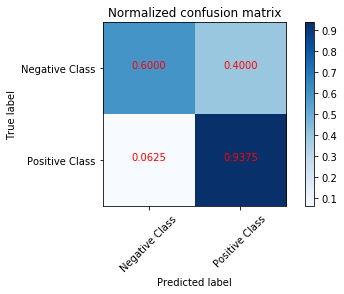

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print('confusion matrix:')
print(cm)
#print('\n')
print('classification report:')
print(classification_report(y_test, y_pred))
plot_confusion_matrix(cm, classes=['Negative Class', 'Positive Class'], normalize=True, title='Normalized confusion matrix')

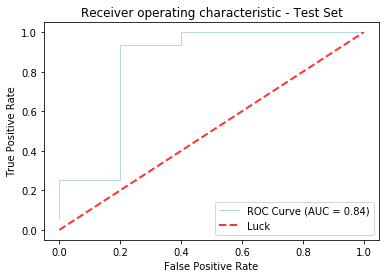

In [ ]:
def plot_roc_curve_lstm(model, X_test, Y_test):
    probas_ = model.predict(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC Curve (AUC = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
plt.title('Receiver operating characteristic - Test Set')
plot_roc_curve_lstm(model,X_test,y_test)

Looking at the confusion matrix, it stands out that the F-1 score corresponding to the positive class is significantly better than the negative class. This is usually the case for binary classification in imbalanced datasets, i.e. datasets where data from one class (the majority class) dominates the other class (minority class) in terms of population. Let's see if that's the case for this dataset:

In [ ]:
nnz_train = np.count_nonzero(y_train) # class 1 population
nz_train = len(y_train) - nnz_train # class 0 population
class_0_ratio = 100* (nz_train / len(y_train))
class_1_ratio = 100* (nnz_train / len(y_train))
print('%0.2f percent of test data belong to the negative class' % class_0_ratio)
print('%0.2f percent of test data belong to the positive class' % class_1_ratio)

# Find out imbalance ratio
imbalance_ratio = nz_train / nnz_train
print('imbalance ratio: %0.2f' % (imbalance_ratio))

29.89 percent of test data belong to the negative class
70.11 percent of test data belong to the positive class
imbalance ratio: 0.43


The above confirms that the dataset is slightly imbalanced. I am going to use this insight in building the next model that is going to hopefully outperform the LSTM model. With that being said, I am going to talk about my second classification approach next.

## Approach 2: Ensemble Tree Classifier
Ensemble trees have become very popular in classification tasks and tend to perform very well on a variety of different applications. Given that the dataset is slightly imbalanced, boosting would be a more suitable approach here than bagging. That is because boosting ensemble models penalize inaccurate classifications through assigning larger weights to misclassified examples on the go as sequential classifiers are trained on the data. With imbalanced datasets, classifiers tend to lean towards the majority class (in the case of this dataset the positive class) and thus penalizing the examples inaccurately predicted as the majority class would be a great way to deal with this issue, which is exactly what boosting does.

As for the choice of the boosting tree, I chose XGBoost over GBM because xgboost is much faster and more efficient computationally. Plus it is more robust to overfitting. In other words, there are several parameters that you can tune which allows for model complexity control.

Unlike LSTMs, where you can directly use the reshaped timeseries sequences as inputs to the model, for the tree model, we first need to extract features from the timeseries sequences. Let's start by doing that!

### Feature Extraction
In order to tackle the problem as a classification problem, first step is to come up with a set of features per timeseries instance. I have used the Python package tsfresh to automatically extract features from the time-series data. I have used the minimal settings for feature extraction due to the relatively smaller size of the dataset. This setting extracts time-domain/statistical features (such as the mean, median, std, etc) from the timeseries.

In [ ]:
Train_Feat = tsfresh.extract_features(train, column_id = "ID_TestSet", default_fc_parameters=MinimalFCParameters())

Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 11.89it/s]


In [ ]:
Train_Feat.shape

(184, 112)

In [ ]:
Train_Feat.head()

variable,bl__length,bl__maximum,bl__mean,bl__median,bl__minimum,bl__standard_deviation,bl__sum_values,bl__variance,bm__length,bm__maximum,...,vy__sum_values,vy__variance,vz__length,vz__maximum,vz__mean,vz__median,vz__minimum,vz__standard_deviation,vz__sum_values,vz__variance
id,,,,,,,,,,,,,,,,,,,,,
2,89.0,0.620646,-0.058786,-0.143973,-0.696461,0.329902,-5.231949,0.108835,89.0,0.036065,...,60.362131,0.055065,89.0,2.018660,1.051772,1.017112,0.326891,0.354175,93.607724,0.125440
5,89.0,1.353424,1.150740,1.161086,0.837941,0.092047,102.415857,0.008473,89.0,2.250316,...,-11.035501,0.020595,89.0,0.831245,0.461779,0.462737,0.166135,0.144593,41.098354,0.020907
8,89.0,0.749732,0.440288,0.437344,0.273835,0.075808,39.185674,0.005747,89.0,0.363479,...,-92.830274,0.022782,89.0,-0.851447,-1.194040,-1.198474,-1.433153,0.121798,-106.269563,0.014835
11,89.0,1.047921,0.514709,0.553522,0.113769,0.273098,45.809076,0.074583,89.0,-0.642524,...,-18.734620,0.192510,89.0,2.603694,1.593528,1.682121,0.819042,0.505479,141.823985,0.255509
17,89.0,0.625810,0.394166,0.392594,-0.030377,0.161558,35.080740,0.026101,89.0,-0.860994,...,-87.135102,0.100431,89.0,1.519348,0.337610,0.217468,-1.297308,0.732260,30.047248,0.536205


In [ ]:
Train_Feat.isnull().values.any()

False

In [ ]:
Test_Feat = tsfresh.extract_features(test, column_id = "ID_TestSet", default_fc_parameters=MinimalFCParameters())

Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 108.53it/s]


In [ ]:
Test_Feat.shape

(21, 112)

In [ ]:
Test_Feat.head()

variable,bl__length,bl__maximum,bl__mean,bl__median,bl__minimum,bl__standard_deviation,bl__sum_values,bl__variance,bm__length,bm__maximum,...,vy__sum_values,vy__variance,vz__length,vz__maximum,vz__mean,vz__median,vz__minimum,vz__standard_deviation,vz__sum_values,vz__variance
id,,,,,,,,,,,,,,,,,,,,,
14,89.0,0.793621,0.629412,0.655069,0.063855,0.129215,56.017625,0.016697,89.0,0.105025,...,-128.164987,0.118531,89.0,2.087541,0.940563,1.070664,-0.948264,0.800637,83.710147,0.641020
32,89.0,1.145596,0.850777,0.854292,0.217898,0.133452,75.719156,0.017810,89.0,0.295099,...,-86.273144,0.021967,89.0,0.026155,-0.589594,-0.623121,-1.034794,0.211198,-52.473844,0.044605
59,89.0,0.886563,0.363417,0.262648,0.032444,0.228497,32.344118,0.052211,89.0,0.233673,...,-8.804487,0.500675,89.0,1.371501,-0.060683,-0.067233,-1.145326,0.499182,-5.400825,0.249182
71,89.0,0.694656,0.270456,0.225213,-0.109980,0.183761,24.070567,0.033768,89.0,1.265174,...,7.462708,0.055385,89.0,3.062967,2.200065,2.149967,0.858979,0.400952,195.805774,0.160762
101,89.0,1.349121,0.922886,0.852571,0.600853,0.229401,82.136881,0.052625,89.0,1.521891,...,78.454591,0.245541,89.0,2.882647,1.869759,2.037418,0.000438,0.669740,166.408534,0.448552


Possible extension of the work could be to extract features using a sliding window, rather than from the whole timeseries sequence at once. The model could benefit from the use of sliding window because sliding windows would be better able to capture the variations within the timeseries data. Especially if the timeseries is non-stationary, sliding windows would result in more meaningful features.

### Feature Selection
Looking at dimensions of the train and test set, there are too many features in the dataset compared to the number of examples. Thus, our model could benefit from feature selection. I have used feature importances inherent to ensemble tree classifier XGBoost to select the most informative features and thus reducing the dimensions of the feature space:

In [1]:
from xgboost import plot_importance
model = XGBClassifier()
model.fit(Train_Feat, y_train)
# feature importance
_, ax = plt.subplots(figsize=(10, 20))
plot_importance(model, ax=ax)
plt.show()

NameError: ignored

In [ ]:
print(model.feature_importances_)

In [ ]:
print(sorted(model.feature_importances_, reverse=True))

As the feature importance values confirm, not all features are as important according to the model. Thus, we perform feature selection to avoid overfitting:

In [ ]:
sel_thresh = 0.02
selection = SelectFromModel(model, threshold=sel_thresh, prefit=True)
select_train_feat = selection.transform(Train_Feat)
select_test_feat = selection.transform(Test_Feat)

print(select_train_feat.shape)
print(select_test_feat.shape)

### Building XGboost Model

### Cross Validation

I have used k-fold cross validation to tune XGBoost hyperparameters. Area under the ROC curve has been used to tune parameters; however, depending on the particular applications and whether the costumer wants to put more emphasis on false positives versus false negatives or vice versa, we can choose to tune differently, e.g. use precision, recall, etc instead. Furthermore, to account for the slight imabalnce in data, I have tuned the hyperparameter in XGBoost called "scale_pos_weight" which can be used to adjust the relative class populations.

In [ ]:
cv_params = {
        'min_child_weight': [1, 5],
        'max_depth': [3, 4, 5],
        'scale_pos_weight': [0.3, 0.5, 1],
        }
grid_search = GridSearchCV(XGBClassifier(random_state=0), cv_params, cv = 3, scoring = 'roc_auc', n_jobs=-1, verbose=5)
grid_search.fit(select_train_feat, y_train)
grid_search.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] scale_pos_weight=0.3, min_child_weight=1, max_depth=3 ...........
[CV] scale_pos_weight=0.3, min_child_weight=1, max_depth=3 ...........
[CV] scale_pos_weight=0.3, min_child_weight=1, max_depth=3 ...........
[CV] scale_pos_weight=0.5, min_child_weight=1, max_depth=3 ...........
[CV]  scale_pos_weight=0.3, min_child_weight=1, max_depth=3, score=0.687339 -   0.1s
[CV]  scale_pos_weight=0.3, min_child_weight=1, max_depth=3, score=0.565891 -   0.1s
[CV] scale_pos_weight=0.5, min_child_weight=1, max_depth=3 ...........
[CV] scale_pos_weight=0.5, min_child_weight=1, max_depth=3 ...........
[CV]  scale_pos_weight=0.3, min_child_weight=1, max_depth=3, score=0.709914 -   0.1s
[CV] scale_pos_weight=1, min_child_weight=1, max_depth=3 .............
[CV]  scale_pos_weight=0.5, min_child_weight=1, max_depth=3, score=0.685435 -   0.1s
[CV] scale_pos_weight=1, min_child_weight=1, max_depth=3 .............
[CV]  scale_pos_weight=0.5, min

[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.4s


[CV]  scale_pos_weight=0.5, min_child_weight=1, max_depth=4, score=0.716034 -   0.1s
[CV]  scale_pos_weight=0.5, min_child_weight=1, max_depth=4, score=0.664083 -   0.1s
[CV] scale_pos_weight=0.3, min_child_weight=5, max_depth=4 ...........
[CV] scale_pos_weight=0.5, min_child_weight=5, max_depth=4 ...........
[CV]  scale_pos_weight=1, min_child_weight=1, max_depth=4, score=0.713586 -   0.1s
[CV] scale_pos_weight=1, min_child_weight=1, max_depth=4 .............
[CV]  scale_pos_weight=0.3, min_child_weight=5, max_depth=4, score=0.483204 -   0.0s
[CV] scale_pos_weight=0.3, min_child_weight=5, max_depth=4 ...........
[CV]  scale_pos_weight=0.5, min_child_weight=5, max_depth=4, score=0.637699 -   0.1s
[CV] scale_pos_weight=0.5, min_child_weight=5, max_depth=4 ...........
[CV]  scale_pos_weight=1, min_child_weight=1, max_depth=4, score=0.737726 -   0.1s
[CV] scale_pos_weight=0.3, min_child_weight=5, max_depth=4 ...........
[CV]  scale_pos_weight=0.3, min_child_weight=5, max_depth=4, score=0

[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    1.1s finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Now, let's fit the best classifier to the training data:

In [ ]:
clf = grid_search.best_estimator_

### Model Evaluation

In [ ]:
clf.fit(select_train_feat, y_train)
y_pred = clf.predict(select_test_feat)
accuracy_score(y_test, y_pred)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9047619047619048

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print('confusion matrix:')
print(cm)
#print('\n')
print('classification report:')
print(classification_report(y_test, y_pred))

confusion matrix:
[[ 4  1]
 [ 1 15]]
classification report:
             precision    recall  f1-score   support

          0       0.80      0.80      0.80         5
          1       0.94      0.94      0.94        16

avg / total       0.90      0.90      0.90        21



In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red")
                 #color="red" if cm[i, j] > thresh else "black")
    #plt.set_tight_layout(True)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.8    0.2   ]
 [0.0625 0.9375]]


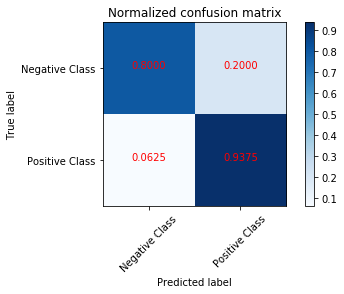

In [ ]:
plot_confusion_matrix(cm, classes=['Negative Class', 'Positive Class'], normalize=True, title='Normalized confusion matrix')

In [ ]:
def plot_roc_curve(model, X_test, Y_test):
    probas_ = model.predict_proba(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC Curve (AUC = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

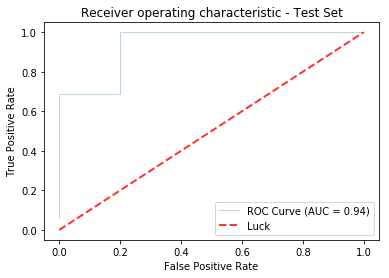

In [ ]:
plt.title('Receiver operating characteristic - Test Set')
plot_roc_curve(clf,select_test_feat,y_test)

As the results show, the XGBoost model trained on manually-extracted timeseries features outperforms the LSTM model on this dataset.

## Anomaly Detection Analysis

In this section, I am going to briefly explain how I would tackle this problem as an anomaly detection problem rather than a classification problem.



Unlike classification which is a supervised learning method, anomaly/outlier detection is often tackled as an unsupervised learning problem where examples that deviate from the expected behavior of data are detected as anomalies. Datasets containing anomalies generally suffer from class imbalance problem, which we saw earlier in the analysis is the case for this dataset with slight imbalance present. In re-formulating binary classification in imbalanced data as an anomaly detection problem, we can think of the minority class as anomalies in the data and the data belonging to the majority class as regular examples (i.e. not anomalies).

Here are some ideas that I have as for how to tackle this data from an outlier detection point of view:

### Supervised
* Use LSTM/RNN to train a regression (rather than classification) model to perform time series forecast, i.e. predicting feature values in the timeseries data. For each feature in the multivariate time series, make a prediction as for what the next value is going to be - then compare the predicted feature value with the actual value (using groundtruth). Threshold this difference in the two values (would require tuning of this threshold value as a hyperparameter). If the difference exceeds the threshold, that would be indicative of some sort of anomaly/event occuring within the time series and the instance would be detected as an anomaly. For multivariate series, we would also need to come up with a mechanism to combine decisions from the thresholding of the various features in order to label the time series as a whole. The simplest idea would be to do some sort of majority voting, i.e. if the forcasted value for the majority of the features deviates heavily from the actual feature value, label the time series as anomaly.

### Unsupervised
* Simplest idea is to use clustering techniques such as K-means. A common metric for time series clustering is dynamic time warping (DTW)
* SVM's have also been showing to be promising for unsupervised anomaly detection
